# Bayesian Neural Net Demo in Turing.jl

Load packages.

In [1]:
using Turing, Gadfly, Reactive, Interact

Generate some data points.

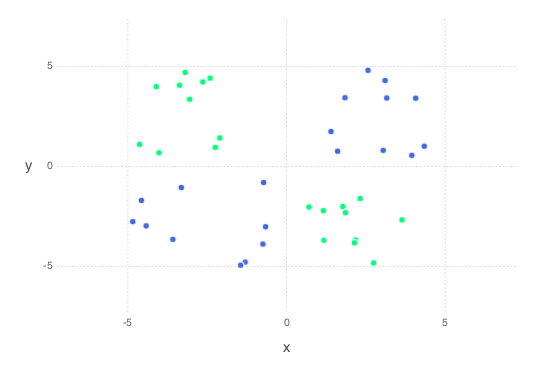

In [2]:
N = 40; M = round(Int, N / 4); srand(1234)

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

xs = [xt1s; xt0s]; ts = [ones(2*M); zeros(2*M)]

# Plot data points
d1_layer = layer(x=map(e -> e[1], xt1s), y=map(e -> e[2], xt1s), Geom.point, Theme(default_color=colorant"royalblue"))
d2_layer = layer(x=map(e -> e[1], xt0s), y=map(e -> e[2], xt0s), Geom.point, Theme(default_color=colorant"springgreen"))
plot(d1_layer, d2_layer, Coord.Cartesian(xmin=-7, xmax=7, ymin=-7, ymax=7))

Define the sigmoid function $$ f(x) = 1 / (1 + e^{-x}) $$ for later use.

In [3]:
sigmoid{T<:Real}(x::Union{T,Vector{T},Matrix{T}}) = one(T) ./ (one(T) + exp(-x))
;

Define a feed forward neural network shown in the diagram.

<img width="33%" src="nn-diagram.png">

In [4]:
nn_forward(x, W₁, b₁, W₂, b₂, wₒ, bₒ) = begin
    h₁ = tanh(W₁' * x + b₁)
    h₂ = tanh(W₂' * h₁ + b₂)
    sigmoid(wₒ' * h₂ + bₒ)
end

nn_forward (generic function with 1 method)

Define a Bayes NN in Turing.jl.

In [5]:
alpha = 0.09            # regularizatin term
var = sqrt(1.0 / alpha) # variance of the Gaussian prior

@model bayes_nn(xs, ts) = begin
    W₁ = Matrix{Real}(2, 3)
    W₁ ~ [MvNormal(zeros(2), var * ones(2))]
    b₁ ~ MvNormal(zeros(3), var * ones(3))

    W₂ = Matrix{Real}(3, 2)
    W₂ ~ [MvNormal(zeros(3), var * ones(3))]
    b₂ ~ MvNormal(zeros(2), var * ones(2))

    wₒ ~ MvNormal(zeros(2), var * ones(2))
    bₒ ~ Normal(0, var)
    
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(nn_forward(xs[i], W₁, b₁, W₂, b₂, wₒ, bₒ)[1])
    end
end

bayes_nn (generic function with 3 methods)

Run inference.

In [6]:
N = 2000
ch = sample(bayes_nn(xs, ts), HMC(N, 0.05, 4));

[Turing]:  Assume - `W₁` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `b₁` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `W₂` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `b₂` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `wₒ` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `bₒ` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Observe - `ts` is an observation
  in @~(::Any, ::Any) at compiler.jl:35


[HMC] Sampling... 99%  ETA: 0:00:00

[HMC] Finished with
  Running time        = 24.394242105;
  Accept rate         = 0.959;
  #lf / sample        = 3.998;
  #evals / sample     = 3.999;


[HMC] Sampling...100% Time: 0:00:26


  pre-cond. diag mat  = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....


Define some helper functions and convert data format for plotting.

In [7]:
na2mat(na) = begin
    ncol = length(na); nrow = length(na[1])
    mat = Matrix{eltype(na[1])}(nrow, ncol)
    for n = 1:ncol mat[:, n] = na[n] end
    mat
end

b₁ = ch[:b₁]; W₁ = map(na->na2mat(na), ch[:W₁])
b₂ = ch[:b₂]; W₂ = map(na->na2mat(na), ch[:W₂])
bₒ = ch[:bₒ]; wₒ = ch[:wₒ]
;

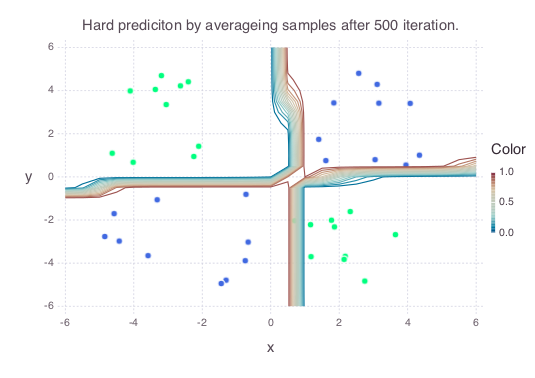

In [8]:
m_W₁, m_b₁, m_W₂, m_b₂, m_wₒ, m_bₒ = mean(W₁[500:end]), mean(b₁[500:end]), mean(W₂[500:end]), mean(b₂[500:end]), mean(wₒ[500:end]), mean(bₒ[500:end])
p_hard_layer = layer(z=(x,y) -> nn_forward([x, y], m_W₁, m_b₁, m_W₂, m_b₂, m_wₒ, m_bₒ)[1], 
                     x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)

plot(p_hard_layer, d1_layer, d2_layer, 
     Coord.cartesian(xmin=-6, xmax=6, ymin=-6, ymax=6),
     Guide.title("Hard prediciton by averageing samples after 500 iteration."))

Now we can do visualization by Bayesian prediciton.

$$ p(\tilde{x} | X, \alpha) = \int_{\theta} p(\tilde{x} | \theta) p(\theta | X, \alpha) = \sum_{\theta \sim p(\theta | X, \alpha)}f_{\theta}(\tilde{x}) $$

In [9]:
nn_predict(x, W₁, b₁, W₂, b₂, Wₒ, bₒ, n_end) = begin
    mean([nn_forward(x, W₁[i], b₁[i], W₂[i], b₂[i], wₒ[i], bₒ[i])[1] for i in 1:20:n_end])
end

nn_predict (generic function with 1 method)

Let's build an interactive plot.

Interact.Options{:SelectionSlider,Int64}(1: "input" = 1050 Int64 ,"n_end",1050,"1050",Interact.OptionDict(DataStructures.OrderedDict("100"=>100,"110"=>110,"120"=>120,"130"=>130,"140"=>140,"150"=>150,"160"=>160,"170"=>170,"180"=>180,"190"=>190…),Dict(1760=>"1760",520=>"520",1090=>"1090",160=>"160",1050=>"1050",300=>"300",1000=>"1000",1570=>"1570",490=>"490",690=>"690"…)),Any[],Any[],true,"horizontal")

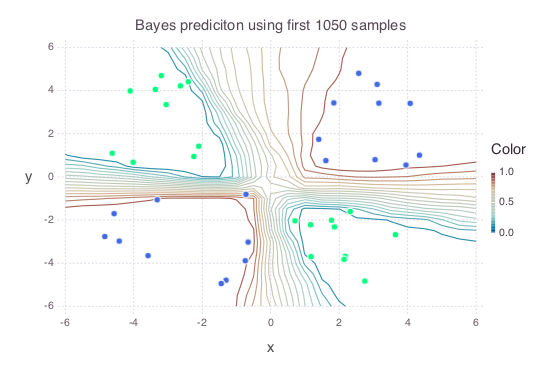

In [10]:
@manipulate for n_end = 100:10:N
    p_layer = layer(z=(x,y) -> nn_predict([x, y], W₁, b₁, W₂, b₂, wₒ, bₒ, n_end), 
                    x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)
    plot(d1_layer, d2_layer, p_layer, 
         Coord.cartesian(xmin=-6, xmax=6, ymin=-6, ymax=6),
         Guide.title("Bayes prediciton using first $n_end samples"))
end

In [11]:
bayes_nn(xs, ts)

[Turing]:  Assume - `W₁` is a parameter (ignoring `W₁` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `b₁` is a parameter (ignoring `b₁` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `W₂` is a parameter (ignoring `W₂` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `b₂` is a parameter (ignoring `b₂` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `wₒ` is a parameter (ignoring `wₒ` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `bₒ` is a parameter (ignoring `bₒ` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Observe - `ts` is an observation
  in @~(::Any, ::Any) at compiler.jl:35


bayes_nn_model_##292 (generic function with 1 method)